In [1]:
# Ячейка 1: Настройка окружения
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from scipy import stats
import warnings

# Настройки отображения
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Настройка стиля графиков
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [2]:
# Ячейка 2: Загрузка данных из всех файлов
def load_and_combine_results(results_dir='./results'):
    """Загружает и объединяет все результаты из CSV файлов"""
    
    print("📂 Загрузка результатов экспериментов...")
    
    all_dfs = []
    pattern = os.path.join(results_dir, '*_full.csv')
    csv_files = sorted(glob.glob(pattern))
    
    if not csv_files:
        print(f"❌ Файлы не найдены по шаблону: {pattern}")
        print(f"Текущая директория: {os.getcwd()}")
        print(f"Содержимое папки results:")
        print(glob.glob("./results/*"))
        return None
    
    print(f"✅ Найдено {len(csv_files)} файлов:")
    
    for file_path in csv_files:
        try:
            filename = os.path.basename(file_path)
            dataset_name = filename.split('_')[0]
            
            df = pd.read_csv(file_path)
            
            # Проверяем наличие нужных колонок
            if 'sparsity_target' not in df.columns:
                # Пробуем найти колонку с разреженностью под другим именем
                for col in df.columns:
                    if 'sparsity' in col.lower():
                        df = df.rename(columns={col: 'sparsity_target'})
                        break
            
            # Добавляем колонку с именем датасета
            if 'dataset' not in df.columns:
                df['dataset'] = dataset_name
            
            # Проверяем наличие всех необходимых колонок
            required_cols = ['sparsity_target', 'accuracy', 'inference_time_ms']
            missing_cols = [col for col in required_cols if col not in df.columns]
            
            if missing_cols:
                print(f"  ⚠️ {filename}: отсутствуют колонки {missing_cols}")
            else:
                print(f"  ✅ {filename}: {len(df)} строк, датасет: {dataset_name}")
                all_dfs.append(df)
                
        except Exception as e:
            print(f"  ❌ Ошибка при загрузке {filename}: {e}")
    
    if all_dfs:
        combined_df = pd.concat(all_dfs, ignore_index=True)
        print(f"\n📊 Объединённый DataFrame:")
        print(f"   • Строк: {len(combined_df)}")
        print(f"   • Датасеты: {combined_df['dataset'].unique().tolist()}")
        print(f"   • Уровни разреженности: {sorted(combined_df['sparsity_target'].unique())}")
        print(f"   • Колонки: {combined_df.columns.tolist()}")
        
        # Показываем первые строки для проверки
        print(f"\nПервые 3 строки данных:")
        print(combined_df[['dataset', 'sparsity_target', 'accuracy', 'inference_time_ms']].head(3))
        
        return combined_df
    else:
        print("❌ Нет данных для анализа")
        return None

# Загружаем данные
df = load_and_combine_results()

📂 Загрузка результатов экспериментов...
✅ Найдено 6 файлов:
  ✅ Citeseer_20251217_020358_full.csv: 18 строк, датасет: Citeseer
  ✅ Cora_20251217_010115_full.csv: 6 строк, датасет: Cora
  ✅ Cora_20251217_010918_full.csv: 6 строк, датасет: Cora
  ✅ Cora_20251217_012440_full.csv: 6 строк, датасет: Cora
  ✅ Cora_20251217_020302_full.csv: 18 строк, датасет: Cora
  ✅ Pubmed_20251217_020934_full.csv: 18 строк, датасет: Pubmed

📊 Объединённый DataFrame:
   • Строк: 72
   • Датасеты: ['Citeseer', 'Cora', 'Pubmed']
   • Уровни разреженности: [0.0, 0.1, 0.3, 0.5, 0.7, 0.9]
   • Колонки: ['run_id', 'sparsity_target', 'sparsity_actual', 'accuracy', 'baseline_accuracy', 'inference_time_ms', 'inference_std_ms', 'model_size_mb', 'flops', 'num_params', 'hidden_channels', 'dataset', 'timestamp']

Первые 3 строки данных:
    dataset  sparsity_target  accuracy  inference_time_ms
0  Citeseer              0.0     0.684           3.660788
1  Citeseer              0.0     0.675           3.495360
2  Citeseer 

In [3]:
# Ячейка 3: Создание сводной таблицы
def create_summary_table(df):
    """Создаёт сводную таблицу с результатами"""
    
    if df is None or len(df) == 0:
        print("❌ Нет данных для создания таблицы")
        return None
    
    print("📋 Создание сводной таблицы...")
    
    summary_rows = []
    
    for dataset in df['dataset'].unique():
        dataset_data = df[df['dataset'] == dataset]
        
        # Находим baseline
        baseline_mask = dataset_data['sparsity_target'] == 0.0
        if baseline_mask.any():
            baseline = dataset_data[baseline_mask]
            baseline_acc = baseline['accuracy'].mean()
            baseline_time = baseline['inference_time_ms'].mean()
        else:
            print(f"⚠️ Для {dataset} нет baseline (sparsity=0.0)")
            continue
        
        # Для каждого уровня разреженности
        sparsities = sorted([s for s in dataset_data['sparsity_target'].unique() if s > 0])
        
        for sparsity in sparsities:
            mask = dataset_data['sparsity_target'] == sparsity
            subset = dataset_data[mask]
            
            if len(subset) > 0:
                avg_acc = subset['accuracy'].mean()
                avg_time = subset['inference_time_ms'].mean()
                
                accuracy_drop = baseline_acc - avg_acc
                speedup = baseline_time / avg_time if avg_time > 0 else 1
                
                summary_rows.append({
                    'Датасет': dataset,
                    'Разреженность': sparsity,
                    'Точность': avg_acc,
                    'Потеря точности': accuracy_drop,
                    'Время (мс)': avg_time,
                    'Ускорение': speedup,
                    'Количество запусков': len(subset)
                })
    
    if summary_rows:
        summary_df = pd.DataFrame(summary_rows)
        
        # Форматирование для отображения
        display_df = summary_df.copy()
        display_df['Точность'] = display_df['Точность'].apply(lambda x: f"{x:.4f}")
        display_df['Потеря точности'] = display_df['Потеря точности'].apply(lambda x: f"{x:.4f}")
        display_df['Время (мс)'] = display_df['Время (мс)'].apply(lambda x: f"{x:.2f}")
        display_df['Ускорение'] = display_df['Ускорение'].apply(lambda x: f"{x:.2f}x")
        
        print("\n📊 СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ:")
        print("="*80)
        print(display_df.to_string(index=False))
        
        # Сохраняем в CSV
        timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
        output_path = f'summary_table_{timestamp}.csv'
        summary_df.to_csv(output_path, index=False)
        print(f"\n💾 Таблица сохранена в: {output_path}")
        
        return summary_df
    else:
        print("❌ Не удалось создать сводную таблицу")
        return None

# Создаём сводную таблицу
summary_df = create_summary_table(df)

📋 Создание сводной таблицы...

📊 СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ:
 Датасет  Разреженность Точность Потеря точности Время (мс) Ускорение  Количество запусков
Citeseer            0.1   0.6743          0.0050       3.51     1.02x                    3
Citeseer            0.3   0.6423          0.0370       3.50     1.02x                    3
Citeseer            0.5   0.5837          0.0957       3.80     0.94x                    3
Citeseer            0.7   0.4227          0.2567       4.04     0.88x                    3
Citeseer            0.9   0.3663          0.3130       3.72     0.96x                    3
    Cora            0.1   0.7900          0.0100       5.50     1.00x                    6
    Cora            0.3   0.7863          0.0137       5.55     0.99x                    6
    Cora            0.5   0.7083          0.0917       5.53     0.99x                    6
    Cora            0.7   0.6602          0.1398       5.66     0.97x                    6
    Cora            0.9   0.

📈 Построение графиков...

💾 Графики сохранены в: analysis_results_20251217_023837.png


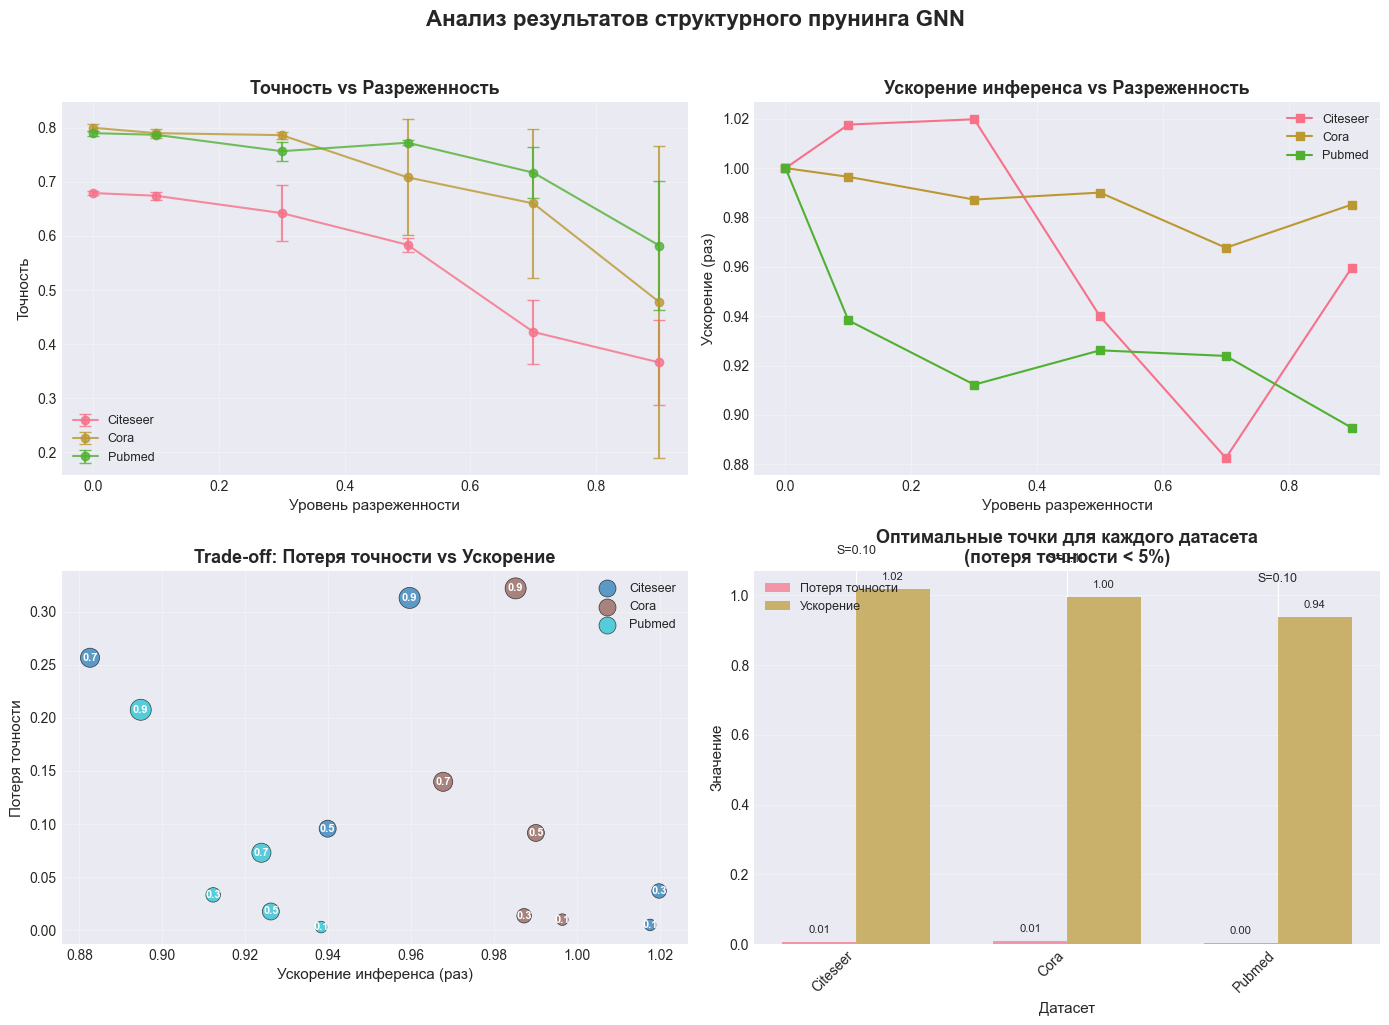

In [4]:
# Ячейка 4: Построение основных графиков
def plot_main_results(df):
    """Строит основные графики результатов"""
    
    if df is None or len(df) == 0:
        print("❌ Нет данных для графиков")
        return
    
    print("📈 Построение графиков...")
    
    # Создаём фигуру с 4 графиками
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # --- График 1: Точность vs Разреженность ---
    ax = axes[0, 0]
    
    for dataset in df['dataset'].unique():
        dataset_data = df[df['dataset'] == dataset]
        
        # Группируем и считаем среднее и стандартное отклонение
        grouped = dataset_data.groupby('sparsity_target').agg({
            'accuracy': ['mean', 'std'],
            'inference_time_ms': 'mean'
        })
        
        sparsity = grouped.index
        accuracy_mean = grouped[('accuracy', 'mean')]
        accuracy_std = grouped[('accuracy', 'std')]
        
        # Строим график с доверительными интервалами
        ax.errorbar(sparsity, accuracy_mean, yerr=accuracy_std,
                   marker='o', markersize=6, capsize=4, linewidth=1.5,
                   label=dataset, alpha=0.8)
    
    ax.set_xlabel('Уровень разреженности', fontsize=11)
    ax.set_ylabel('Точность', fontsize=11)
    ax.set_title('Точность vs Разреженность', fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-0.05, df['sparsity_target'].max() * 1.05)
    
    # --- График 2: Ускорение инференса ---
    ax = axes[0, 1]
    
    for dataset in df['dataset'].unique():
        dataset_data = df[df['dataset'] == dataset]
        
        # Находим baseline время
        baseline_mask = dataset_data['sparsity_target'] == 0.0
        if baseline_mask.any():
            baseline_time = dataset_data[baseline_mask]['inference_time_ms'].mean()
        else:
            continue
        
        # Группируем и считаем ускорение
        grouped = dataset_data.groupby('sparsity_target').agg({
            'inference_time_ms': 'mean'
        })
        
        speedup = baseline_time / grouped['inference_time_ms']
        
        ax.plot(grouped.index, speedup, marker='s', markersize=6, 
                linewidth=1.5, label=dataset)
    
    ax.set_xlabel('Уровень разреженности', fontsize=11)
    ax.set_ylabel('Ускорение (раз)', fontsize=11)
    ax.set_title('Ускорение инференса vs Разреженность', fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-0.05, df['sparsity_target'].max() * 1.05)
    
    # --- График 3: Trade-off анализ ---
    ax = axes[1, 0]
    
    # Подготавливаем данные для scatter plot
    scatter_data = []
    
    for dataset in df['dataset'].unique():
        dataset_data = df[df['dataset'] == dataset]
        
        # Baseline
        baseline_mask = dataset_data['sparsity_target'] == 0.0
        if not baseline_mask.any():
            continue
            
        baseline_data = dataset_data[baseline_mask]
        baseline_acc = baseline_data['accuracy'].mean()
        baseline_time = baseline_data['inference_time_ms'].mean()
        
        # Пруненые модели
        pruned_data = dataset_data[dataset_data['sparsity_target'] > 0]
        
        for sparsity in sorted(pruned_data['sparsity_target'].unique()):
            mask = pruned_data['sparsity_target'] == sparsity
            subset = pruned_data[mask]
            
            if len(subset) > 0:
                avg_acc = subset['accuracy'].mean()
                avg_time = subset['inference_time_ms'].mean()
                
                accuracy_drop = baseline_acc - avg_acc
                speedup = baseline_time / avg_time
                
                scatter_data.append({
                    'dataset': dataset,
                    'sparsity': sparsity,
                    'accuracy_drop': accuracy_drop,
                    'speedup': speedup
                })
    
    if scatter_data:
        scatter_df = pd.DataFrame(scatter_data)
        
        # Цвета для разных датасетов
        unique_datasets = scatter_df['dataset'].unique()
        colors = plt.cm.tab10(np.linspace(0, 1, len(unique_datasets)))
        
        for idx, dataset in enumerate(unique_datasets):
            mask = scatter_df['dataset'] == dataset
            subset = scatter_df[mask]
            
            # Размер точек пропорционален уровню разреженности
            sizes = subset['sparsity'] * 200 + 50
            
            scatter = ax.scatter(subset['speedup'], subset['accuracy_drop'],
                               s=sizes, c=[colors[idx]], alpha=0.7,
                               label=dataset, edgecolors='black', linewidth=0.5)
            
            # Аннотации с уровнем разреженности
            for _, row in subset.iterrows():
                ax.annotate(f"{row['sparsity']:.1f}",
                           (row['speedup'], row['accuracy_drop']),
                           fontsize=8, ha='center', va='center',
                           color='white', fontweight='bold')
    
    ax.set_xlabel('Ускорение инференса (раз)', fontsize=11)
    ax.set_ylabel('Потеря точности', fontsize=11)
    ax.set_title('Trade-off: Потеря точности vs Ускорение', fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(True, alpha=0.3)
    
    # --- График 4: Оптимальные точки для каждого датасета ---
    ax = axes[1, 1]
    
    # Находим оптимальные точки (максимальное ускорение при потере точности < 5%)
    optimal_points = []
    
    for dataset in df['dataset'].unique():
        dataset_data = df[df['dataset'] == dataset]
        
        # Baseline
        baseline_mask = dataset_data['sparsity_target'] == 0.0
        if not baseline_mask.any():
            continue
            
        baseline_data = dataset_data[baseline_mask]
        baseline_acc = baseline_data['accuracy'].mean()
        baseline_time = baseline_data['inference_time_ms'].mean()
        
        # Ищем оптимальную точку
        best_point = None
        best_efficiency = -1
        
        pruned_data = dataset_data[dataset_data['sparsity_target'] > 0]
        
        for sparsity in sorted(pruned_data['sparsity_target'].unique()):
            mask = pruned_data['sparsity_target'] == sparsity
            subset = pruned_data[mask]
            
            if len(subset) > 0:
                avg_acc = subset['accuracy'].mean()
                avg_time = subset['inference_time_ms'].mean()
                
                accuracy_drop = baseline_acc - avg_acc
                speedup = baseline_time / avg_time
                
                # Эффективность: ускорение при минимальной потере точности
                if accuracy_drop > 0:
                    efficiency = speedup / accuracy_drop
                    
                    # Приемлемая потеря точности (< 5%)
                    if accuracy_drop < 0.05 and efficiency > best_efficiency:
                        best_efficiency = efficiency
                        best_point = {
                            'dataset': dataset,
                            'sparsity': sparsity,
                            'accuracy_drop': accuracy_drop,
                            'speedup': speedup,
                            'efficiency': efficiency
                        }
        
        if best_point:
            optimal_points.append(best_point)
    
    if optimal_points:
        optimal_df = pd.DataFrame(optimal_points)
        
        # Bar plot
        x = np.arange(len(optimal_df))
        width = 0.35
        
        bars1 = ax.bar(x - width/2, optimal_df['accuracy_drop'], 
                      width, label='Потеря точности', alpha=0.7)
        bars2 = ax.bar(x + width/2, optimal_df['speedup'], 
                      width, label='Ускорение', alpha=0.7)
        
        ax.set_xlabel('Датасет', fontsize=11)
        ax.set_ylabel('Значение', fontsize=11)
        ax.set_title('Оптимальные точки для каждого датасета\n(потеря точности < 5%)', 
                    fontsize=13, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(optimal_df['dataset'], rotation=45, ha='right')
        ax.legend(loc='upper left', fontsize=9)
        ax.grid(True, alpha=0.3, axis='y')
        
        # Добавляем значения на столбцы
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                       f'{height:.2f}', ha='center', va='bottom', fontsize=8)
        
        # Добавляем аннотации с уровнем разреженности
        for i, row in optimal_df.iterrows():
            ax.text(i, max(row['accuracy_drop'], row['speedup']) + 0.1,
                   f"S={row['sparsity']:.2f}", ha='center', fontsize=9)
    else:
        ax.axis('off')
        ax.text(0.5, 0.5, 'Не найдено оптимальных точек\n(потеря точности < 5%)',
                ha='center', va='center', fontsize=12)
    
    # Общая настройка
    plt.suptitle('Анализ результатов структурного прунинга GNN', 
                 fontsize=16, fontweight='bold', y=1.02)
    
    plt.tight_layout()
    
    # Сохраняем график
    timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
    output_path = f'analysis_results_{timestamp}.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    
    print(f"\n💾 Графики сохранены в: {output_path}")
    plt.show()
    
    return optimal_df

# Строим графики
optimal_points = plot_main_results(df)

🎨 Создание дополнительных визуализаций...
💾 Дополнительные графики сохранены в: additional_plots_20251217_024014.png


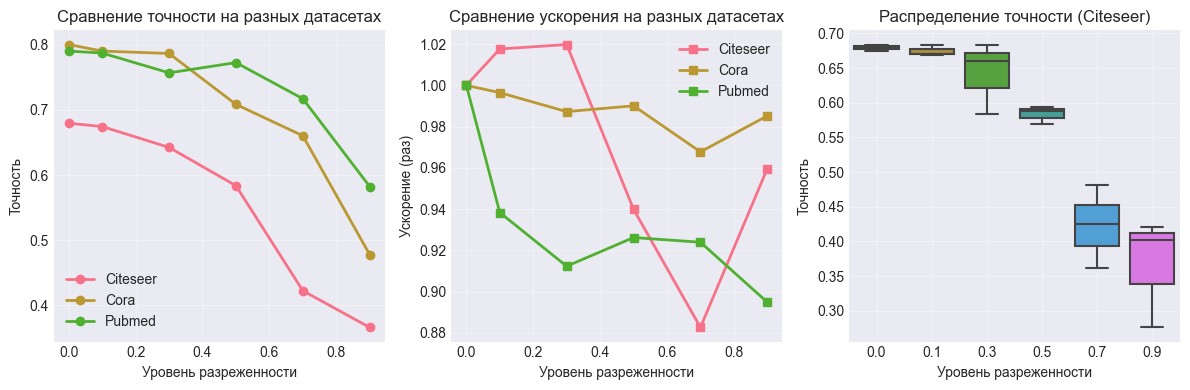

In [5]:
# Ячейка 7: Дополнительные графики для отчёта
def plot_additional_visualizations(df):
    """Создаёт дополнительные визуализации для отчёта"""
    
    if df is None or len(df) == 0:
        return
    
    print("🎨 Создание дополнительных визуализаций...")
    
    # График 1: Сравнение датасетов на одном графике
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 3, 1)
    for dataset in df['dataset'].unique():
        dataset_data = df[df['dataset'] == dataset]
        grouped = dataset_data.groupby('sparsity_target')['accuracy'].mean()
        plt.plot(grouped.index, grouped.values, marker='o', label=dataset, linewidth=2)
    
    plt.xlabel('Уровень разреженности')
    plt.ylabel('Точность')
    plt.title('Сравнение точности на разных датасетах')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 2)
    for dataset in df['dataset'].unique():
        dataset_data = df[df['dataset'] == dataset]
        baseline = dataset_data[dataset_data['sparsity_target'] == 0.0]
        if len(baseline) > 0:
            baseline_time = baseline['inference_time_ms'].mean()
            grouped = dataset_data.groupby('sparsity_target')['inference_time_ms'].mean()
            speedup = baseline_time / grouped
            plt.plot(grouped.index, speedup, marker='s', label=dataset, linewidth=2)
    
    plt.xlabel('Уровень разреженности')
    plt.ylabel('Ускорение (раз)')
    plt.title('Сравнение ускорения на разных датасетах')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 3, 3)
    # Боксплоты распределения точности по уровням разреженности
    import seaborn as sns
    
    # Выбираем один датасет для примера
    if len(df['dataset'].unique()) > 0:
        example_dataset = df['dataset'].unique()[0]
        example_data = df[df['dataset'] == example_dataset]
        
        # Преобразуем sparsity_target в строки для категориального отображения
        example_data['sparsity_str'] = example_data['sparsity_target'].apply(lambda x: f"{x:.1f}")
        
        sns.boxplot(x='sparsity_str', y='accuracy', data=example_data)
        plt.xlabel('Уровень разреженности')
        plt.ylabel('Точность')
        plt.title(f'Распределение точности ({example_dataset})')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Сохраняем
    timestamp = pd.Timestamp.now().strftime('%Y%m%d_%H%M%S')
    output_path = f'additional_plots_{timestamp}.png'
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    
    print(f"💾 Дополнительные графики сохранены в: {output_path}")
    plt.show()

# Создаём дополнительные графики
plot_additional_visualizations(df)